In [1]:
import pandas as pd
import seaborn as sns
import os
import requests
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score, ConfusionMatrixDisplay
import torch
from transformers import DistilBertTokenizer
from transformers.data.processors.utils import InputFeatures
from transformers import AutoConfig, DistilBertForSequenceClassification, DistilBertModel, DistilBertTokenizer, DistilBertConfig, EarlyStoppingCallback, TrainingArguments, Trainer
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F


pd.options.display.max_columns = 100
%matplotlib inline

# Data Reading

In [2]:
def download_file(url):
    filename = url.split('/')[-1]
    if not os.path.exists(filename):
        response = requests.get(url)
        open(filename, 'wb').write(response.content)
        print(f'{filename} downloaded')
    else:
        print(f'{filename} already exists')

In [3]:
download_file('https://raw.githubusercontent.com/t-davidson/hate-speech-and-offensive-language/master/data/labeled_data.csv')

labeled_data.csv already exists


In [4]:
df = pd.read_csv("labeled_data.csv", usecols=["class","tweet"])
print(f"[Train] the dataframe shape: {df.shape}")
df

[Train] the dataframe shape: (24783, 2)


,class,tweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...
24778,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24779,2,"you've gone and broke the wrong heart baby, an..."
24780,1,young buck wanna eat!!.. dat nigguh like I ain...
24781,1,youu got wild bitches tellin you lies


# Data Visualization

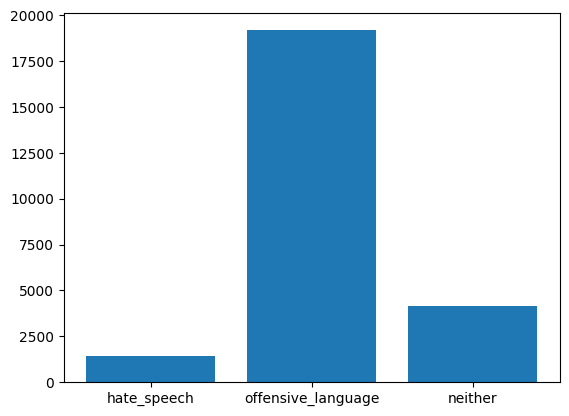

In [5]:
temp_df = df['class'].value_counts().sort_index()
x_labels = ['hate_speech','offensive_language', 'neither']
plt.xticks(range(1, 4), x_labels)
plt.bar(x=range(1,4), height=temp_df.to_list());

# Data Split

In [6]:
train, test = train_test_split(df, test_size=0.2, random_state=42, stratify=df['class'] )
train, val = train_test_split(train, test_size=0.2, random_state=42, stratify=train['class'] )

# Data transformation

In [7]:
# Use cuda if it's available
if torch.cuda.is_available():      
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [8]:
# Preparing dataset for the distilBert model
class ClassificationDataset(Dataset):
    def __init__(self, text, target):
        super(ClassificationDataset).__init__()
        self.text = text
        self.target = target
        self.tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
        self.max_len = 512
      
    def __len__(self):
        return len(self.text)

    def __getitem__(self,item):
        text = str(self.text[item])
        text = " ".join(text.split())
        
        inputs = self.tokenizer(
            text,
            max_length=self.max_len,
            padding='max_length',
            truncation=True
        )      
        return InputFeatures(**inputs,label=self.target[item])

In [9]:
train_dataset = ClassificationDataset(
    train["tweet"].to_list(),
    train["class"].to_list()
)
val_dataset = ClassificationDataset(
    val["tweet"].to_list(),
    val["class"].to_list()
)
test_dataset = ClassificationDataset(
    test["tweet"].to_list(),
    test["class"].to_list()
)

# Model Building

In [10]:
# Modified version of the focal loss
def softmax_focal_loss_with_regularization(inputs, targets, model, alpha = None, gamma = 2, reduction = "none", reg_type: str = "l2", reg_weight: float = 1e-3):
    ce_loss = F.cross_entropy(inputs, targets, reduction="none")
    p = torch.exp(-ce_loss)
    loss = ce_loss * ((1 - p) ** gamma)
    
    # Alpha weighting for different classes
    if alpha is not None:
        batch_size, num_classes = inputs.size()
        class_mask = torch.zeros((batch_size, num_classes), device=inputs.device)
        class_mask.scatter_(1, targets.unsqueeze(1), 1.)
        alpha_t = torch.sum(alpha.to(inputs.device) * class_mask.to(inputs.device), dim=1)
        loss = alpha_t * loss
    
    # L1/L2 regularization
    reg_loss = 0
    for param in model.parameters():
        if reg_type == "l1":
            reg_loss += torch.sum(torch.abs(param))
        else:
            reg_loss += torch.sum(param ** 2)
    loss = loss + reg_weight * reg_loss

    if reduction == "none":
        pass
    elif reduction == "mean":
        loss = loss.mean()
    elif reduction == "sum":
        loss = loss.sum()
    else:
        raise ValueError(f"Invalid Value for arg 'reduction': '{reduction} \\n Supported reduction modes: 'none', 'mean', 'sum'")
    
    return loss

In [11]:
class CustomClassificationModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.distilbert = DistilBertModel.from_pretrained('distilbert-base-uncased')
        self.pre_classifier = nn.Linear(self.distilbert.config.dim, 256)
        self.dropout = nn.Dropout(0.2)
        self.classifier1 = nn.Linear(256, 64)
        self.classifier2 = nn.Linear(64, 3)

    def forward(self, input_ids, attention_mask=None, labels=None):
        distilbert_output = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = distilbert_output[0]
        out = hidden_state[:, 0]
        out = self.pre_classifier(out)
        out = nn.ReLU()(out)
        out = self.dropout(out)
        out = self.classifier1(out)
        out = nn.ReLU()(out)
        out = self.dropout(out)
        logits = self.classifier2(out)
        # alpha = torch.tensor([0.5,0.1,0.4])
        # loss = softmax_focal_loss_with_regularization(logits.view(-1, 3), labels.view(-1), self, alpha)
        loss = softmax_focal_loss_with_regularization(logits.view(-1, 3), labels.view(-1), self)
        
        return (loss.mean(), logits)
    
model = CustomClassificationModel() 

# Model Training

In [12]:
# Metrics for evaluation
def compute_metrics(p): 
    preds = np.argmax(p.predictions, axis=1)
    macro_f1 = f1_score(p.label_ids,preds,average='macro')
    precision = precision_score(p.label_ids,preds,average='macro', zero_division=1)
    recall = recall_score(p.label_ids,preds,average='macro')
    acc = accuracy_score(p.label_ids,preds)
    return {       
      'macro_f1' : macro_f1,
      'Validation accuracy': acc,
      'Precision': precision,
      'Recall' : recall,
}

In [13]:
# Huggingface trainer config
training_args = TrainingArguments( 
    output_dir= "./train",    
    adam_epsilon = 1e-8,
    learning_rate = 1e-5,
    per_device_train_batch_size = 16, # set to 16 due to memory issue
    per_device_eval_batch_size = 128,
    gradient_accumulation_steps = 2, # use this to scale batch size without needing more memory
    num_train_epochs= 5,
    evaluation_strategy = 'steps',
    save_strategy = 'steps',
    load_best_model_at_end = True,
    metric_for_best_model = 'macro_f1',
    greater_is_better = True,
    seed = 42,
    weight_decay=0.0001, # Weight decay for regularization
    logging_steps=100,
  )

In [14]:
# Early stopping to prevent overfitting
early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=3,
    early_stopping_threshold=0.01,
)

# Huggingface Trainer class
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

In [15]:
# Train the model
training_logs = trainer.train()

Step,Training Loss,Validation Loss,Macro F1,Validation accuracy,Precision,Recall
100,171.131700,168.488617,0.290938,0.774332,0.924777,0.333333
200,166.309300,164.172577,0.560674,0.870651,0.863320,0.600564
300,162.374200,160.577286,0.587221,0.892587,0.907948,0.600601
400,158.908300,157.280746,0.598668,0.900656,0.911400,0.620928
500,155.735800,154.198288,0.606441,0.906959,0.915768,0.633049
600,152.665800,151.176941,0.597539,0.899899,0.917994,0.611196
700,149.849800,148.538162,0.651772,0.908976,0.807893,0.650546
800,147.328800,146.158340,0.621840,0.901916,0.765734,0.614609
900,145.095100,144.001373,0.658724,0.914271,0.817292,0.664976
1000,142.908500,141.851532,0.644597,0.911498,0.818163,0.646856


In [16]:
# Save the model
torch.save(trainer.model.state_dict(), "./my-model.pth")

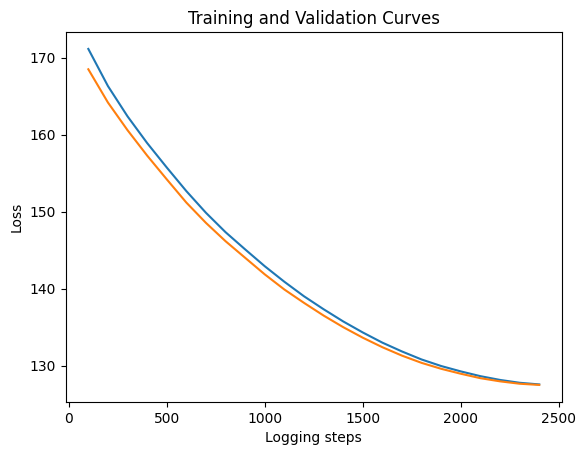

In [17]:
# Compute training and validation curve
train_loss_list = [log['loss'] for log in trainer.state.log_history if 'loss' in log]
eval_loss_list = [log['eval_loss'] for log in trainer.state.log_history if 'eval_loss' in log]
step_list = [log['step'] for log in trainer.state.log_history if 'loss' in log]
plt.plot(step_list, train_loss_list, label='Training loss')
plt.plot(step_list, eval_loss_list, label='Validation loss')
plt.xlabel('Logging steps')
plt.ylabel('Loss')
plt.title('Training and Validation Curves')
plt.show()

In [18]:
# Compute test accuracy
test_predictions = trainer.predict(test_dataset)
test_predicted_labels = test_predictions.predictions.argmax(axis=1)
test_labels = test['class'].to_list()
test_accuracy = accuracy_score(test_labels, test_predicted_labels)

print('Test Accuracy:', test_accuracy)

Test Accuracy: 0.9138591890256204


In [19]:
label_map = {i:v for i, v in enumerate(x_labels)}
example_dataset = ClassificationDataset(
    test["tweet"].to_list()[:100],
    test["class"].to_list()[:100]
)

def find_unsuccessful(pred, target):
    for i, (a, b) in enumerate(zip(pred, target)):
        if a != b:
            return i
        
def find_successful(pred, target):
    for i, (a, b) in enumerate(zip(pred, target)):
        if a == b:
            return i

example_predictions = trainer.predict(example_dataset)
example_predicted_labels = example_predictions.predictions.argmax(axis=1)
example_predicted_labels = [list(label_map.keys())[value] for value in example_predicted_labels]
example_labels = test["class"].to_list()[:100]

unsuccessful_index = find_unsuccessful(example_predicted_labels, example_labels)
successful_index = find_successful(example_predicted_labels, example_labels)

print("Successful example:")
print(test["tweet"].to_list()[successful_index])
print("Expected prediction:", example_labels[successful_index])
print("Actual prediction:", example_predicted_labels[successful_index])
print("")
print("Unsuccessful example:")
print(test["tweet"].to_list()[unsuccessful_index])
print("Expected prediction:", example_labels[unsuccessful_index])
print("Actual prediction:", example_predicted_labels[unsuccessful_index])

Successful example:
RT @JimNorton: There is a GIFT SHOP at the 9-11 museum? And they charge admission. It's a mass grave you fucking cunts. What a disgrace.
Expected prediction: 1
Actual prediction: 1

Unsuccessful example:
RT @obeyyreggie: stfu hoe RT &#8220;@tedddydgaf: "I'm proud to be African American" 
- Proud African American

"I'm proud to be white" 
- Racist
&#8230;
Expected prediction: 0
Actual prediction: 1


In [20]:
print(classification_report(test_labels, test_predicted_labels, target_names=x_labels, zero_division=0))


                    precision    recall  f1-score   support

       hate_speech       0.50      0.30      0.38       286
offensive_language       0.94      0.96      0.95      3838
           neither       0.87      0.92      0.89       833

          accuracy                           0.91      4957
         macro avg       0.77      0.73      0.74      4957
      weighted avg       0.90      0.91      0.91      4957



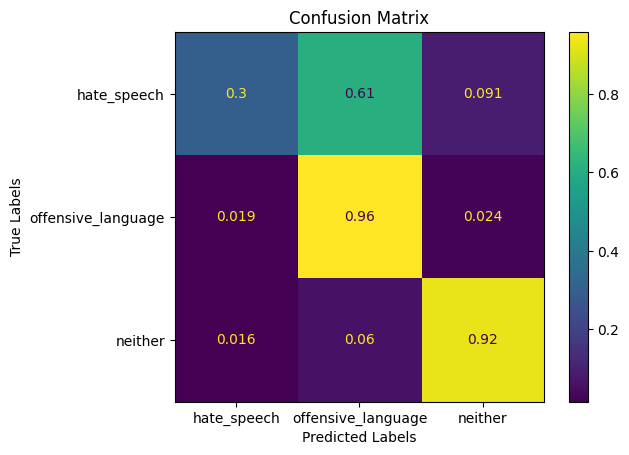

In [21]:
cm = ConfusionMatrixDisplay(confusion_matrix(test_labels, test_predicted_labels, normalize ='true'), display_labels=x_labels)
cm.plot()
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()